## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import tensorflow as tf
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.model_selection as skl
from sklearn import metrics
from sklearn.utils import class_weight
from random import sample 

from itertools import chain

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.layers import *

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
%pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import efficientnet.keras as efn 
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

ModuleNotFoundError: No module named 'efficientnet'

## Do some early processing of your metadata for easier model training:

In [5]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
70585,00017405_036.png,No Finding,36,17405,65,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_008/images/00017405_036.png
110582,00030129_003.png,Infiltration,3,30129,61,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_012/images/00030129_003.png
56292,00014022_023.png,Infiltration,23,14022,65,M,AP,2500,2048,0.168000,0.168000,NaN,/data/images_007/images/00014022_023.png


In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    else:
        print(c_label)

All Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [7]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25370,00006675_000.png,No Finding,0,6675,54,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26927,00007034_004.png,No Finding,4,7034,30,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4272,00001167_000.png,Consolidation|Fibrosis|Infiltration|Nodule,0,1167,51,F,PA,2992,2991,0.143,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = 0

In [9]:
all_xray_df.loc[all_xray_df['Pneumonia'] == 1.0, 'pneumonia_class'] = 1

In [10]:
all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].astype(str)

In [11]:
all_xray_df_less_100 = all_xray_df[all_xray_df['Patient Age'] <= 100]

In [12]:
all_xray_df_less_100[all_xray_df_less_100['Pneumonia'] == 1.0]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [13]:
'Frequency pneumonia: {}%'.format(sum(all_xray_df_less_100.Pneumonia == 1.0)/len(all_xray_df_less_100)*100)

'Frequency pneumonia: 1.2756012274316706%'

In [14]:
# stat on other disease comorbid pneumonia:
all_xray_df_less_100[all_xray_df_less_100.Pneumonia==1.0]['Finding Labels'].value_counts()[1:15]/sum(all_xray_df_less_100.Pneumonia==1.0)

Infiltration|Pneumonia                         0.139161
Edema|Infiltration|Pneumonia                   0.095804
Atelectasis|Pneumonia                          0.075524
Edema|Pneumonia                                0.058042
Effusion|Pneumonia                             0.037063
Effusion|Infiltration|Pneumonia                0.029371
Consolidation|Pneumonia                        0.025175
Atelectasis|Infiltration|Pneumonia             0.023776
Atelectasis|Effusion|Pneumonia                 0.016084
Edema|Effusion|Infiltration|Pneumonia          0.014685
Edema|Effusion|Pneumonia                       0.013287
Nodule|Pneumonia                               0.013287
Atelectasis|Effusion|Infiltration|Pneumonia    0.012587
Atelectasis|Consolidation|Pneumonia            0.010490
Name: Finding Labels, dtype: float64

In [15]:
# stat on other disease comorbid pneumonia:
all_xray_df_less_100[all_xray_df_less_100.Pneumonia==0]['Finding Labels'].value_counts()[1:15]/sum(all_xray_df_less_100.Pneumonia==0)

Infiltration                0.086253
Atelectasis                 0.038076
Effusion                    0.035736
Nodule                      0.024441
Pneumothorax                0.019815
Mass                        0.019327
Effusion|Infiltration       0.014484
Atelectasis|Infiltration    0.012198
Consolidation               0.011837
Atelectasis|Effusion        0.010526
Pleural_Thickening          0.010174
Cardiomegaly                0.009876
Emphysema                   0.008060
Infiltration|Nodule         0.007490
Name: Finding Labels, dtype: float64

In [16]:
all_xray_df_less_100[all_xray_df_less_100.Pneumonia==1.0]['View Position'].value_counts()/sum(all_xray_df_less_100.Pneumonia==1.0)

AP    0.559441
PA    0.440559
Name: View Position, dtype: float64

In [17]:
len(all_xray_df_less_100['Patient ID'].unique())/len(all_xray_df_less_100)

0.2747627203311211

In [18]:
len(all_xray_df_less_100[all_xray_df_less_100.Pneumonia == 1.0]['Patient ID'].unique())/len(all_xray_df_less_100[all_xray_df_less_100.Pneumonia == 1.0])

0.7048951048951049

## Create your training and testing data:

In [19]:
def create_splits(data_frame, standart=True, test=False):    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    # st
    if standart:
        train_data, val_data = skl.train_test_split(
            data_frame, 
            test_size=0.2, 
            stratify=data_frame['pneumonia_class'],
            random_state=42
        )
        # training set equal postive and negative number cases
        p_inds = train_data[train_data.Pneumonia==1].index.tolist()
        np_inds = train_data[train_data.Pneumonia==0].index.tolist()
        np_sample = sample(np_inds,len(p_inds))
        train_data = train_data.loc[p_inds + np_sample]
        # let's say that clinical prevalence of penumonia for our case is 10%
        p_val_inds = val_data[val_data.Pneumonia==1].index.tolist()
        np_val_inds = val_data[val_data.Pneumonia==0].index.tolist()
        np_val_sample = sample(np_val_inds,len(p_val_inds)*9)
        val_data = val_data.loc[p_val_inds + np_val_sample]
    else:
        train_data, val_data = skl.train_test_split(
            data_frame, 
            test_size=0.2, 
            stratify=data_frame['pneumonia_class'],
            random_state=42
        )
        p_inds = train_data[train_data.Pneumonia==1].index.tolist()
        np_inds = train_data[train_data.Pneumonia==0].index.tolist()
        np_sample = sample(np_inds,int(len(np_inds)/10))
        train_data = train_data.loc[p_inds + np_sample]
        # same for validation set:
        p_val_inds = val_data[val_data.Pneumonia==1].index.tolist()
        np_val_inds = val_data[val_data.Pneumonia==0].index.tolist()
        np_val_sample = sample(np_val_inds,int(len(np_val_inds)/10))
        val_data = val_data.loc[p_val_inds + np_val_sample]
        if test:
            test_data, val_data = skl.train_test_split(
                val_data, 
                test_size=0.5, 
                stratify=val_data['pneumonia_class'],
                random_state=42
            )
            return train_data, (val_data, test_data)
    return train_data, val_data

In [20]:
t, v = create_splits(all_xray_df_less_100)

In [21]:
t.shape, v.shape

((2288, 29), (2860, 29))

In [22]:
train_pneumonia = len(t[t['Pneumonia'] == 1.0])
valid_pneumonia = len(v[v['Pneumonia'] == 1.0])
print('Training number cases: {} Validation number cases: {}'.format(t.shape[0], v.shape[0]))
print('Pneumonia training number cases: {} Pneumonia validation number cases: {}'.format(
    train_pneumonia, valid_pneumonia
))
print('Pneumonia training frequency: {} Pneumina validation frequency: {}'.format(
    train_pneumonia/t.shape[0], 
    valid_pneumonia/v.shape[0])
)

Training number cases: 2288 Validation number cases: 2860
Pneumonia training number cases: 1144 Pneumonia validation number cases: 286
Pneumonia training frequency: 0.5 Pneumina validation frequency: 0.1


In [23]:
# stat on other disease comorbid pneumonia:
t[t.Pneumonia==1.0]['Finding Labels'].value_counts()[1:15]/len(t[t.Pneumonia==1.0])

Infiltration|Pneumonia                         0.137238
Edema|Infiltration|Pneumonia                   0.102273
Atelectasis|Pneumonia                          0.078671
Edema|Pneumonia                                0.056818
Effusion|Pneumonia                             0.038462
Consolidation|Pneumonia                        0.027098
Effusion|Infiltration|Pneumonia                0.025350
Atelectasis|Infiltration|Pneumonia             0.025350
Atelectasis|Effusion|Pneumonia                 0.016608
Edema|Effusion|Infiltration|Pneumonia          0.014860
Nodule|Pneumonia                               0.013986
Edema|Effusion|Pneumonia                       0.013986
Atelectasis|Consolidation|Pneumonia            0.011364
Atelectasis|Effusion|Infiltration|Pneumonia    0.010490
Name: Finding Labels, dtype: float64

In [24]:
# stat on other disease comorbid no pneumonia cases:
t[t.Pneumonia==0]['Finding Labels'].value_counts()[1:15]/len(t[t.Pneumonia==0])

Infiltration                0.085664
Effusion                    0.037587
Atelectasis                 0.036713
Nodule                      0.026224
Pneumothorax                0.023601
Atelectasis|Infiltration    0.015734
Mass                        0.013986
Atelectasis|Effusion        0.013986
Effusion|Infiltration       0.012238
Cardiomegaly                0.011364
Fibrosis                    0.008741
Edema                       0.008741
Emphysema                   0.008741
Infiltration|Nodule         0.007867
Name: Finding Labels, dtype: float64

In [25]:
t[t.Pneumonia==1.0]['View Position'].value_counts()/sum(t.Pneumonia==1.0)

AP    0.558566
PA    0.441434
Name: View Position, dtype: float64

In [26]:
v[v.Pneumonia==1.0]['View Position'].value_counts()/sum(v.Pneumonia==1.0)

AP    0.562937
PA    0.437063
Name: View Position, dtype: float64

In [27]:
t[t.Pneumonia==0]['View Position'].value_counts()/sum(t.Pneumonia==0)

PA    0.608392
AP    0.391608
Name: View Position, dtype: float64

In [28]:
v[v.Pneumonia==0]['View Position'].value_counts()/sum(v.Pneumonia==0)

PA    0.605284
AP    0.394716
Name: View Position, dtype: float64

In [29]:
t[t.Pneumonia == 0]['Patient Gender'].value_counts()/sum(t.Pneumonia == 0)

M    0.56993
F    0.43007
Name: Patient Gender, dtype: float64

In [30]:
v[v.Pneumonia == 0]['Patient Gender'].value_counts()/sum(v.Pneumonia == 0)

M    0.564491
F    0.435509
Name: Patient Gender, dtype: float64

In [31]:
t[t.Pneumonia == 1.0]['Patient Gender'].value_counts()/sum(t.Pneumonia == 1.0)

M    0.583916
F    0.416084
Name: Patient Gender, dtype: float64

In [32]:
v[v.Pneumonia == 1.0]['Patient Gender'].value_counts()/sum(v.Pneumonia == 1.0)

M    0.590909
F    0.409091
Name: Patient Gender, dtype: float64

In [33]:
len(t['Patient ID'].unique())/len(t)

0.777972027972028

In [34]:
len(v['Patient ID'].unique())/len(v)

0.8311188811188811

In [35]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

In [36]:
v['file_path'] = [image_paths[k] for k in v['Image Index'].tolist()]
t['file_path'] = [image_paths[k] for k in t['Image Index'].tolist()]

# Now we can begin our model-building & training

In [37]:
input_size = (224, 224)

#### First suggestion: perform some image augmentation on your data

In [38]:
def my_image_augmentation(train=False):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    if train:
        my_idg = keras.preprocessing.image.ImageDataGenerator(
            rescale=1. / 255.0,
            horizontal_flip=True,
            vertical_flip=False,
            zoom_range=0.2,
            rotation_range=20,
        )
    else:
        my_idg = keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.0,
        )
    return my_idg


def make_train_gen(my_train_idg, data_frame, input_size, batch_size=16):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(
         dataframe=data_frame, 
         directory=None, 
         x_col = 'file_path',
         y_col = 'pneumonia_class',
         class_mode = 'binary',
         target_size=input_size, 
         batch_size=batch_size 
    )
    return train_gen


def make_val_gen(my_val_idg, val_data, input_size, batch_size=16):
    
    val_gen = my_val_idg.flow_from_dataframe(
        dataframe = val_data, 
        directory=None, 
        x_col='file_path',
        y_col='pneumonia_class',
        class_mode='binary',
        target_size=input_size, 
        batch_size=batch_size 
    )     
    return val_gen

In [39]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_generator = my_image_augmentation(train=True)
val_generator = my_image_augmentation(train=False)

In [40]:
train_gen = make_train_gen(train_generator, t, input_size)
val_gen = make_val_gen(val_generator, v, input_size)
valX, valY = val_gen.next()

Found 2288 validated image filenames belonging to 2 classes.
Found 2860 validated image filenames belonging to 2 classes.


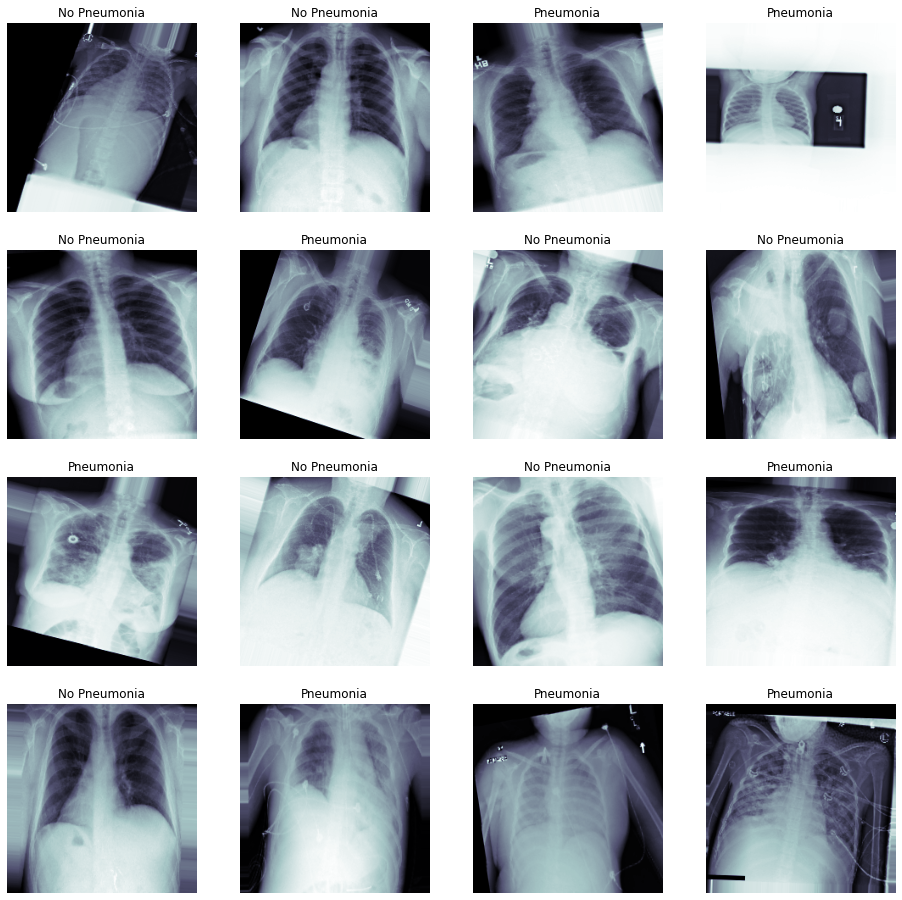

In [41]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [42]:
def get_model(model_name, input_size):        
    if model_name == 'EfficientNetB1':
        model = efn.EfficientNetB1(
            weights='imagenet', 
            include_top=False, 
            pooling = "avg", 
            input_shape=(*input_size, 3)
        )
    elif model_name == 'Vgg16':
        model = VGG16(
            weights='imagenet', 
            include_top=False, 
            input_shape=(*input_size, 3)
        )
    elif model_name == 'ResNet50':
        model = ResNet50(
            weights='imagenet', 
            include_top=False, 
            input_shape=(*input_size, 3)
        )
    for layer in model.layers:
        layer.trainable = False        
    final_model = model
    return final_model

In [44]:
def build_my_model(
    base_model,
    model_name,
    optimizer,
    loss='binary_crossentropy',
    metrics = ['binary_accuracy'],
):
    my_model = Sequential()    
    my_model.add(base_model)
    if model_name == 'EfficientNetB1':
        my_model.add(Dense(16, activation='relu'))
        my_model.add(Dropout(0.5))
        my_model.add(Dense(8, activation='relu'))
        my_model.add(Dropout(0.5))
        my_model.add(Dense(1, activation='sigmoid'))
    elif model_name == 'Vgg16':
        my_model.add(Flatten())        
        my_model.add(Dense(512, activation='relu'))
        my_model.add(Dropout(0.5))
        my_model.add(Dense(256, activation='relu'))
        my_model.add(Dropout(0.5))
        my_model.add(Dense(1, activation='sigmoid'))        
    elif model_name == 'ResNet50':
        my_model.add(GlobalAveragePooling2D())        
        my_model.add(Dropout(0.5))
        my_model.add(Dense(8, activation='relu'))
        my_model.add(Dropout(0.5))
        my_model.add(Dense(1, activation='sigmoid'))                
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    # also make sure you set your optimizer, loss function, and metrics to monitor
    return my_model
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results


### additional_callback for simplier debugging:
class LossHistory(keras.callbacks.Callback):
    def __init__(self,display=150):
        """
        display: Number of batches to wait before outputting loss
        """
        self.seen = 0
        self.display = display
        
    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            # you can access loss, accuracy in self.params['metrics']
            print('\n{} - loss ....\n'.format(self.seen)) 

In [45]:
# plot results
def plot_history(ax, epochs, history):
    for key in history.history.keys():
        ax.plot(range(epochs), history.history[key], label=key)
    ax.legend()
    ax.set_title(model_names[idx])
    return

In [46]:
t_alt, v_alt = create_splits(all_xray_df_less_100, standart=False)
t_alt.shape, v_alt.shape

((9997, 29), (2499, 29))

In [47]:
# Prove that all cases (postive/negative are present):
len(t_alt[t_alt['pneumonia_class'] == '1']), len(v_alt[v_alt['pneumonia_class'] == '1'])

(1144, 286)

In [22]:
# Let's try same things but with auc metrics and weighted_binary_crossentropy
# https://arxiv.org/pdf/1711.05225.pdf 
# auc is better for such type of classification tasks (skewed distribution of penumonia cases versus non-pneumonia)
class_weights = class_weight.compute_sample_weight(
    'balanced', 
    t_alt['pneumonia_class'].tolist()
)
epochs = 4
input_size = (224, 224)
t_alt, v_alt = create_splits(all_xray_df_less_100, standart=False)

v_alt['file_path'] = [image_paths[k] for k in v_alt['Image Index'].tolist()]
t_alt['file_path'] = [image_paths[k] for k in t_alt['Image Index'].tolist()]

train_gen = make_train_gen(train_generator, t_alt, input_size, batch_size=32)
val_gen = make_val_gen(val_generator, v_alt, input_size)
valX, valY = val_gen.next()

model_names = ['Vgg16', 'ResNet50', 'EfficientNetB1']
histories = []

for model_name in model_names:
    final_model = get_model(model_name, input_size)
    my_model = build_my_model(
        base_model=final_model,
        model_name=model_name,
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics = [tf.keras.metrics.AUC()]
    )
    history = my_model.fit_generator(
        train_gen,
        validation_data = (valX, valY), 
        epochs=epochs,
        class_weight=class_weights
    )
    histories.append(history)

Found 9997 validated image filenames belonging to 2 classes.
Found 2499 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Epoch 1/2
 44/313 [===>..........................] - ETA: 4:05 - loss: 0.4669 - auc: 0.4747

KeyboardInterrupt: 

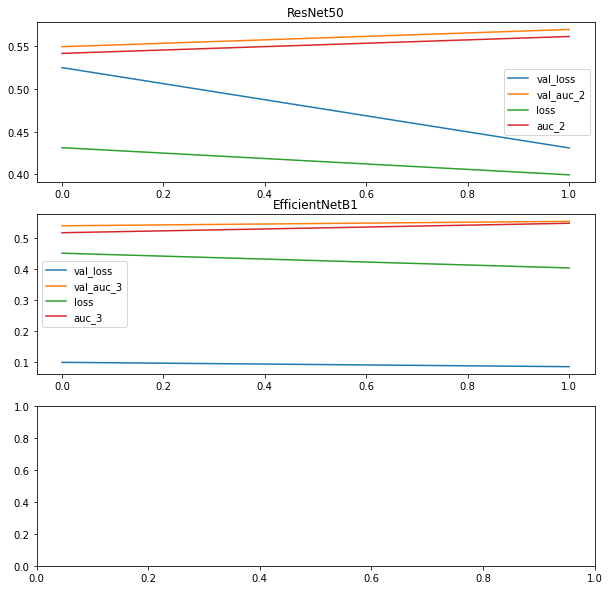

In [44]:
fig, axes = plt.subplots(3, figsize=(10,10))
for idx, history in enumerate(histories):
    plot_history(axes[idx], epochs, history)

In [38]:
# Let's try same things but with auc metrics and weighted_binary_crossentropy
# https://arxiv.org/pdf/1711.05225.pdf 
# auc is better for such type of classification tasks (skewed distribution of penumonia cases versus non-pneumonia)
t_alt, (v_alt, test_alt) = create_splits(all_xray_df_less_100, standart=False, test=True)

class_weights = class_weight.compute_sample_weight(
    'balanced', 
    t_alt['pneumonia_class'].tolist()
)

v_alt['file_path'] = [image_paths[k] for k in v_alt['Image Index'].tolist()]
t_alt['file_path'] = [image_paths[k] for k in t_alt['Image Index'].tolist()]
test_alt['file_path'] = [image_paths[k] for k in test_alt['Image Index'].tolist()]

# Let's split validation data set into validation and test set
train_gen = make_train_gen(train_generator, t_alt, input_size, batch_size=32)
val_gen = make_val_gen(val_generator, v_alt, input_size)
valX, valY = val_gen.next()

test_gen = make_val_gen(val_generator, test_alt, input_size)



# find which version is beast (except vgg16, it seems quite old and alredy outdated model):
model_name = 'ResNet50'

## train your model
# Todo
epochs = 20
input_size = (224, 224)
final_model = get_model(model_name, input_size)
my_model = build_my_model(
    base_model=final_model,
    model_name=model_name,
    optimizer=tf.keras.optimizers.RMSprop(),
    metrics = [tf.keras.metrics.AUC()]
)
my_model.summary()

Found 9997 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.
Found 1249 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 16392     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 23,604,113
Trainable params: 16,401
Non-trainable params: 23,587,712
_____________________________________

In [50]:
t_alt.shape, v_alt.shape, test_alt.shape

((9997, 30), (1250, 30), (1249, 30))

In [40]:
my_model.metrics[0].name

'auc_1'

In [39]:
# Below is some helper code that will allow you to add checkpoints to your model,
# This will save the 'best' version of your model by comparing it to previous epochs of training

# Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
# The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
# improvement before quitting
weight_path="{}_my_model4.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                             monitor='val_'+my_model.metrics[0].name, 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_'+my_model.metrics[0].name,mode='max',patience=10)
callbacks_list = [checkpoint, early]

In [54]:
# proceed_previosu_training= True
# if proceed_previosu_training:
#     my_model.load_weights(weight_path)
#     epochs=6

### Start training! 

In [41]:
history = my_model.fit_generator(
    train_gen,
    validation_data=val_gen, 
    epochs=3,
    class_weight=class_weights,
    callbacks = callbacks_list
)

Epoch 1/3
313/313 [==============================] - 310s 991ms/step - loss: 0.4428 - auc_1: 0.5390 - val_loss: 0.7758 - val_auc_1: 0.5509

Epoch 00001: val_auc_1 improved from -inf to 0.55087, saving model to xray_class_my_model4.best.hdf5
Epoch 2/3
313/313 [==============================] - 269s 860ms/step - loss: 0.4137 - auc_1: 0.5565 - val_loss: 0.3636 - val_auc_1: 0.5580

Epoch 00002: val_auc_1 improved from 0.55087 to 0.55795, saving model to xray_class_my_model4.best.hdf5
Epoch 3/3
313/313 [==============================] - 272s 868ms/step - loss: 0.4014 - auc_1: 0.5589 - val_loss: 0.2741 - val_auc_1: 0.5613

Epoch 00003: val_auc_1 improved from 0.55795 to 0.56132, saving model to xray_class_my_model4.best.hdf5


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [42]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, verbose = True)

16/16 [==============================] - 2s 109ms/step


In [49]:
# proceed training
history = my_model.fit_generator(
    train_gen,
    validation_data=val_gen, 
    epochs=5,
    class_weight=class_weights,
    callbacks = callbacks_list
)

Epoch 1/5
313/313 [==============================] - 278s 887ms/step - loss: 0.3847 - auc_1: 0.5633 - val_loss: 0.2605 - val_auc_1: 0.5646

Epoch 00001: val_auc_1 improved from 0.56132 to 0.56457, saving model to xray_class_my_model4.best.hdf5
Epoch 2/5
313/313 [==============================] - 270s 861ms/step - loss: 0.3736 - auc_1: 0.5669 - val_loss: 0.2587 - val_auc_1: 0.5681

Epoch 00002: val_auc_1 improved from 0.56457 to 0.56813, saving model to xray_class_my_model4.best.hdf5
Epoch 3/5
313/313 [==============================] - 270s 863ms/step - loss: 0.3667 - auc_1: 0.5690 - val_loss: 0.2719 - val_auc_1: 0.5698

Epoch 00003: val_auc_1 improved from 0.56813 to 0.56979, saving model to xray_class_my_model4.best.hdf5
Epoch 4/5
313/313 [==============================] - 270s 864ms/step - loss: 0.3576 - auc_1: 0.5716 - val_loss: 0.8482 - val_auc_1: 0.5720

Epoch 00004: val_auc_1 improved from 0.56979 to 0.57202, saving model to xray_class_my_model4.best.hdf5
Epoch 5/5
313/313 [=====

In [62]:
# proceed training
history2 = my_model.fit_generator(
    train_gen,
    validation_data=val_gen, 
    epochs=3,
    class_weight=class_weights,
    callbacks = callbacks_list
)

Epoch 1/3
313/313 [==============================] - 275s 877ms/step - loss: 0.3529 - auc_1: 0.5746 - val_loss: 0.2203 - val_auc_1: 0.5753

Epoch 00001: val_auc_1 improved from 0.57370 to 0.57533, saving model to xray_class_my_model4.best.hdf5
Epoch 2/3
313/313 [==============================] - 265s 846ms/step - loss: 0.3490 - auc_1: 0.5764 - val_loss: 0.2065 - val_auc_1: 0.5774

Epoch 00002: val_auc_1 improved from 0.57533 to 0.57744, saving model to xray_class_my_model4.best.hdf5
Epoch 3/3
313/313 [==============================] - 267s 855ms/step - loss: 0.3484 - auc_1: 0.5780 - val_loss: 0.2057 - val_auc_1: 0.5790

Epoch 00003: val_auc_1 improved from 0.57744 to 0.57905, saving model to xray_class_my_model4.best.hdf5


In [28]:
my_model.predict_generator?

In [92]:
def plot_auc(t_y, p_y):    
    ## Hint: can use scikit-learn's built in functions here like roc_curve        
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = metrics.roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', metrics.auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = metrics.precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', metrics.average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
#Also consider plotting the history of your model training:

def plot_history(epochs, history):
    for key in history.history.keys():
        plt.plot(range(epochs), history.history[key], label=key)
    plt.show()
    return

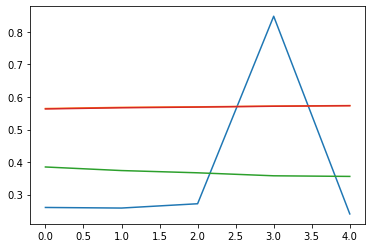

In [70]:
plot_history(5, history)

In [67]:
# in order get x values and y values
test_x_subset = None
test_y_subset = None
test_score_subset = None

for i in range(10):
    testX, testY = test_gen.next()
    if test_x_subset is None:
        test_x_subset = testX
    else:
        test_x_subset = np.concatenate((testX, test_x_subset))
        
    if test_y_subset is None:
        test_y_subset = testY
    else:
        test_y_subset = np.concatenate((testY, test_y_subset))
    pred_y2 = my_model.predict(testX)
    if test_score_subset is None:
        test_score_subset = pred_y2
    else:
        test_score_subset = np.concatenate((pred_y2, test_score_subset))

In [58]:
test_x_subset.shape

(1585, 224, 224, 3)

In [57]:
test_y_subset.shape

(160,)

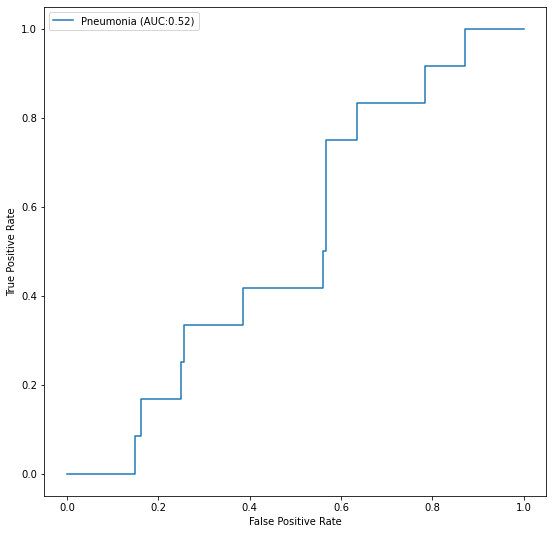

In [68]:
plot_auc(test_y_subset, test_score_subset)

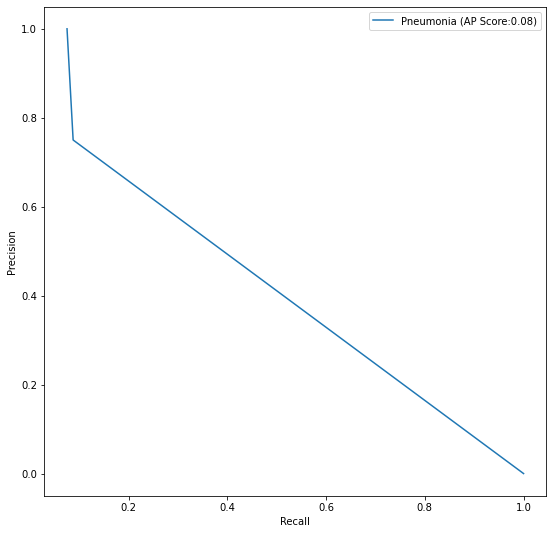

In [93]:
plot_pr(test_y_subset, test_score_subset)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [106]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresh = metrics.precision_recall_curve(test_y_subset, validation_score_subset)

def calc_f1(precision, recall):
    return 2*(precision * recall)/(precision+recall)

In [107]:
f1s = []
for idx, prec in enumerate(precision):
    f1s.append(calc_f1(prec, recall[idx]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [108]:
max_f1s =  max(f1s)
idx = [i for i, j in enumerate(f1s) if j == max_f1s][0]

In [109]:
YOUR_THRESHOLD = thresh[idx]

In [113]:
YOUR_THRESHOLD

0.15953238

In [110]:
testY = validation_score_subset
testY[validation_score_subset > YOUR_THRESHOLD] = 1
testY[validation_score_subset <= YOUR_THRESHOLD] = 0

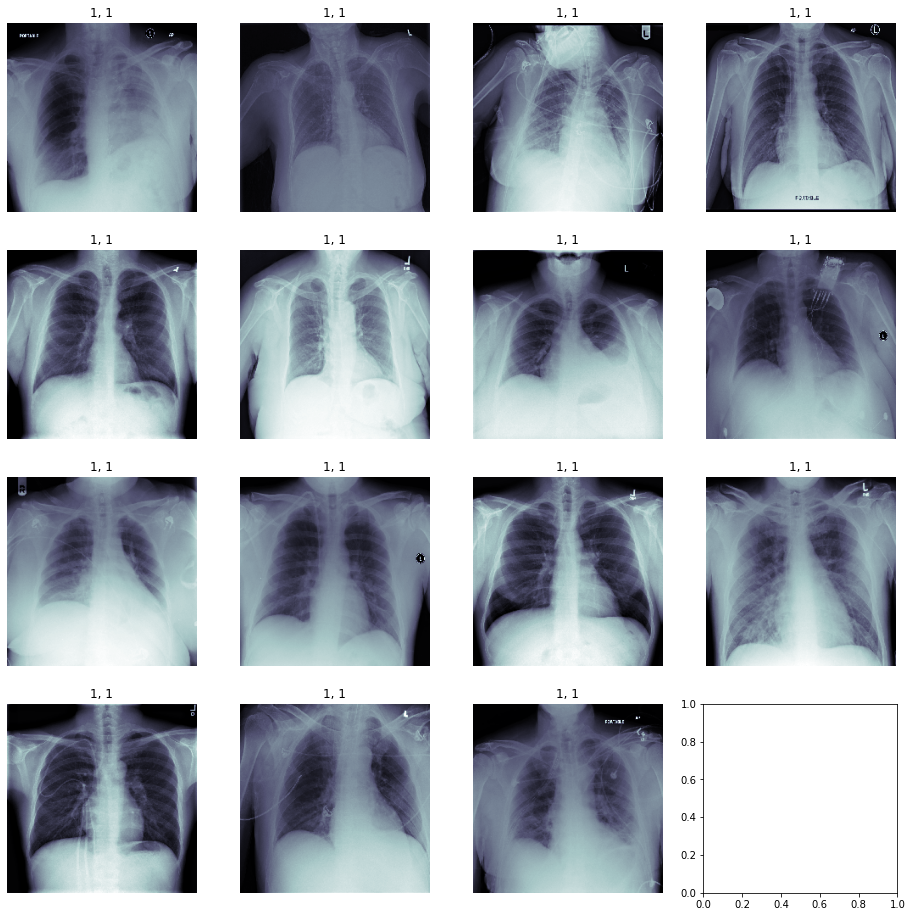

In [115]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:15], testY[0:15], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [94]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)